In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import os
import sklearn 
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
df_narr = pd.read_csv('/content/drive/MyDrive/Classes/2 Practicum/cfpb_cleaned/data_files/STM/stm_labeled_data_v2.0')

In [4]:
df_narr.shape

(657663, 35)

In [5]:
df_narr.head()

,Unnamed: 0,X,Date.received,Product,Sub.product,Issue,Sub.issue,Consumer.complaint.narrative,Company.public.response,Company,State,ZIP.code,Tags,Consumer.consent.provided.,Submitted.via,Date.sent.to.company,Company.response.to.consumer,Timely.response.,Consumer.disputed.,Complaint.ID,Complaint.length,Credit Report Inaccuracies,Unauthorised Accounts and Fraudulent Transactions,"Assets: Vehicles, Real Estate",Identity Theft,Unauthorized Credit Inquiries,"Bank Account Mismanagement: Fees, Charges & Deposits","Loan Mismanagement: Misinformation, Foul-Play","Communications: Robo-Calls, Nuisance, Company Unresponsiveness",Legal Action,Credit Card Promotions/Offers,"Harassment, Customer Service",Disputing Information/Verification,Debt: Disputing Validity,Disputing Late Payments
0,1,0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld system inc try collect debt mine ow...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392,18,0.047128,0.041757,0.017485,0.013969,0.004153,0.003736,0.008741,0.034037,0.022959,0.004236,0.055982,0.047329,0.681091,0.017397
1,2,1,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,past week receive excessive amount telephone c...,NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198,78,0.012458,0.019859,0.006091,0.005754,0.003020,0.003266,0.003513,0.297163,0.006213,0.006871,0.372630,0.013641,0.202014,0.047508
2,3,2,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,pioneer commit several federal violation priva...,NaN,Pioneer Capital Solutions Inc,CA,925XX,NaN,Consent provided,Web,2019-09-15,Closed with explanation,Yes,NaN,3374555,152,0.015170,0.007107,0.020329,0.010550,0.039737,0.001259,0.001388,0.003730,0.667993,0.024531,0.015921,0.022865,0.163697,0.005721
3,4,3,2019-07-26,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,previously request experian send copy verifiab...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,914XX,NaN,Consent provided,Web,2019-07-26,Closed with explanation,Yes,NaN,3319331,171,0.122738,0.078570,0.003249,0.009802,0.005270,0.001067,0.002588,0.014340,0.019251,0.002138,0.010869,0.705005,0.010095,0.015019
4,5,4,2019-07-08,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,hello complaint three credit report company tr...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,109XX,NaN,Consent provided,Web,2019-07-08,Closed with explanation,Yes,NaN,3299394,428,0.149381,0.142992,0.012159,0.078844,0.013872,0.007452,0.004001,0.046901,0.021641,0.006939,0.142531,0.342156,0.018507,0.012625


In [6]:
df_narr.columns

Index(['Unnamed: 0', 'X', 'Date.received', 'Product', 'Sub.product', 'Issue',
       'Sub.issue', 'Consumer.complaint.narrative', 'Company.public.response',
       'Company', 'State', 'ZIP.code', 'Tags', 'Consumer.consent.provided.',
       'Submitted.via', 'Date.sent.to.company', 'Company.response.to.consumer',
       'Timely.response.', 'Consumer.disputed.', 'Complaint.ID',
       'Complaint.length', 'Credit Report Inaccuracies',
       'Unauthorised Accounts and Fraudulent Transactions',
       'Assets: Vehicles, Real Estate', 'Identity Theft',
       'Unauthorized Credit Inquiries',
       'Bank Account Mismanagement: Fees, Charges & Deposits',
       'Loan Mismanagement: Misinformation, Foul-Play',
       'Communications: Robo-Calls, Nuisance, Company Unresponsiveness',
       'Legal Action', 'Credit Card Promotions/Offers',
       'Harassment, Customer Service', 'Disputing Information/Verification',
       'Debt: Disputing Validity', 'Disputing Late Payments'],
      dtype='objec

# Topic Prevalance over time

## STM Model (as of 10-Feb-2021)

### Explaining the Topic Weight

In [7]:
df_narr.columns[::-1][0:14]

#topics

Index(['Disputing Late Payments', 'Debt: Disputing Validity',
       'Disputing Information/Verification', 'Harassment, Customer Service',
       'Credit Card Promotions/Offers', 'Legal Action',
       'Communications: Robo-Calls, Nuisance, Company Unresponsiveness',
       'Loan Mismanagement: Misinformation, Foul-Play',
       'Bank Account Mismanagement: Fees, Charges & Deposits',
       'Unauthorized Credit Inquiries', 'Identity Theft',
       'Assets: Vehicles, Real Estate',
       'Unauthorised Accounts and Fraudulent Transactions',
       'Credit Report Inaccuracies'],
      dtype='object')

In [8]:
df_probs = df_narr.iloc[:, ::-1].iloc[:, 0:14]

df_probs.head()

,Disputing Late Payments,Debt: Disputing Validity,Disputing Information/Verification,"Harassment, Customer Service",Credit Card Promotions/Offers,Legal Action,"Communications: Robo-Calls, Nuisance, Company Unresponsiveness","Loan Mismanagement: Misinformation, Foul-Play","Bank Account Mismanagement: Fees, Charges & Deposits",Unauthorized Credit Inquiries,Identity Theft,"Assets: Vehicles, Real Estate",Unauthorised Accounts and Fraudulent Transactions,Credit Report Inaccuracies
0,0.017397,0.681091,0.047329,0.055982,0.004236,0.022959,0.034037,0.008741,0.003736,0.004153,0.013969,0.017485,0.041757,0.047128
1,0.047508,0.202014,0.013641,0.372630,0.006871,0.006213,0.297163,0.003513,0.003266,0.003020,0.005754,0.006091,0.019859,0.012458
2,0.005721,0.163697,0.022865,0.015921,0.024531,0.667993,0.003730,0.001388,0.001259,0.039737,0.010550,0.020329,0.007107,0.015170
3,0.015019,0.010095,0.705005,0.010869,0.002138,0.019251,0.014340,0.002588,0.001067,0.005270,0.009802,0.003249,0.078570,0.122738
4,0.012625,0.018507,0.342156,0.142531,0.006939,0.021641,0.046901,0.004001,0.007452,0.013872,0.078844,0.012159,0.142992,0.149381


**Output from STM**: 
- We get 14 Probabilities per Complaint, persuant to each Topic.
- We assign each Complaint to a Topic given their highest probability out of the 14, `max_prob`. 

This is not an even distribution: 

```
Harassment, Customer Service                                      94178
Disputing Information/Verification                                74401
Communications: Robo-Calls, Nuisance, Company Unresponsiveness    69502
Debt: Disputing Validity                                          59636
Loan Mismanagement: Misinformation, Foul-Play                     56213
Disputing Late Payments                                           54866
Credit Report Inaccuracies                                        40577
Credit Card Promotions/Offers                                     39327
Unauthorised Accounts and Fraudulent Transactions                 38839
Bank Account Mismanagement: Fees, Charges & Deposits              35854
Unauthorized Credit Inquiries                                     31102
Identity Theft                                                    29362
Assets: Vehicles, Real Estate                                     21075
Legal Action                                                      12731
Name: Topic, dtype: int64
Name: Topic_Num, dtype: int64

```
- We also use the numerical value of `max_prob` as an indication of topic importance, since it means that **more words in the associated complaints are related to the given complaint**. We call this **Topic Weight**. 


### Preprocessing and Descriptives

In [9]:
top_topic = df_probs.idxmax(axis=1)

In [10]:
top_prob = df_probs.max(axis=1)

In [11]:
date_rec = df_narr['Date.received']

date_rec

0         2019-09-24
1         2019-11-08
2         2019-09-15
3         2019-07-26
4         2019-07-08
             ...    
657658    2016-07-11
657659    2017-01-24
657660    2015-03-26
657661    2015-12-12
657662    2016-08-09
Name: Date.received, Length: 657663, dtype: object

In [12]:
df_topic = pd.concat([top_topic, top_prob, date_rec], axis = 1)

df_topic.columns =['Topic', 'max_prob', 'date_rec'] 

In [13]:
df_topic['date_rec'] = pd.to_datetime(df_topic['date_rec'])

In [14]:
df_topic['year'] = pd.DatetimeIndex(df_topic['date_rec']).year
df_topic['month'] = pd.DatetimeIndex(df_topic['date_rec']).month

In [15]:
df_topic 

,Topic,max_prob,date_rec,year,month
0,Debt: Disputing Validity,0.681091,2019-09-24,2019,9
1,"Harassment, Customer Service",0.372630,2019-11-08,2019,11
2,Legal Action,0.667993,2019-09-15,2019,9
3,Disputing Information/Verification,0.705005,2019-07-26,2019,7
4,Disputing Information/Verification,0.342156,2019-07-08,2019,7
...,...,...,...,...,...
657658,Disputing Late Payments,0.417160,2016-07-11,2016,7
657659,"Communications: Robo-Calls, Nuisance, Company ...",0.475167,2017-01-24,2017,1
657660,"Communications: Robo-Calls, Nuisance, Company ...",0.362528,2015-03-26,2015,3
657661,"Loan Mismanagement: Misinformation, Foul-Play",0.362917,2015-12-12,2015,12


In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_topic['Topic_Num'] = le.fit_transform(df_topic['Topic'])

In [17]:
list(le.classes_)

['Assets: Vehicles, Real Estate',
 'Bank Account Mismanagement: Fees, Charges & Deposits',
 'Communications: Robo-Calls, Nuisance, Company Unresponsiveness',
 'Credit Card Promotions/Offers',
 'Credit Report Inaccuracies',
 'Debt: Disputing Validity',
 'Disputing Information/Verification',
 'Disputing Late Payments',
 'Harassment, Customer Service',
 'Identity Theft',
 'Legal Action',
 'Loan Mismanagement: Misinformation, Foul-Play',
 'Unauthorised Accounts and Fraudulent Transactions',
 'Unauthorized Credit Inquiries']

In [18]:
df_topic.head()

,Topic,max_prob,date_rec,year,month,Topic_Num
0,Debt: Disputing Validity,0.681091,2019-09-24,2019,9,5
1,"Harassment, Customer Service",0.372630,2019-11-08,2019,11,8
2,Legal Action,0.667993,2019-09-15,2019,9,10
3,Disputing Information/Verification,0.705005,2019-07-26,2019,7,6
4,Disputing Information/Verification,0.342156,2019-07-08,2019,7,6


In [19]:
df_topic['Topic_Num'].unique()

array([ 5,  8, 10,  6,  2, 12,  7,  9,  3, 13,  4, 11,  0,  1])

In [20]:
df_topic['Topic_Num'].value_counts()

8     94178
6     74401
2     69502
5     59636
11    56213
7     54866
4     40577
3     39327
12    38839
1     35854
13    31102
9     29362
0     21075
10    12731
Name: Topic_Num, dtype: int64

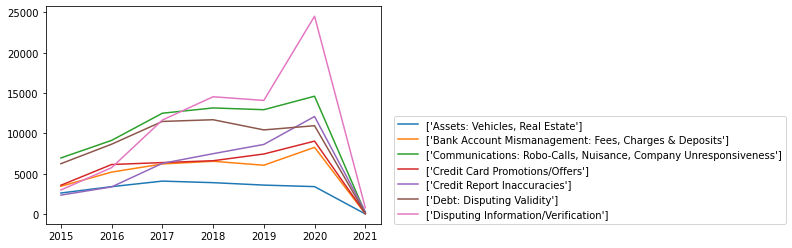

In [21]:
for x in range(0, 7): 
  plt.plot(df_topic[df_topic['Topic_Num'] == x]['Topic'].groupby(df_topic['year']).agg('count'), label = df_topic[df_topic['Topic_Num'] == x]['Topic'].unique())
  plt.legend(loc=(1.04,0))

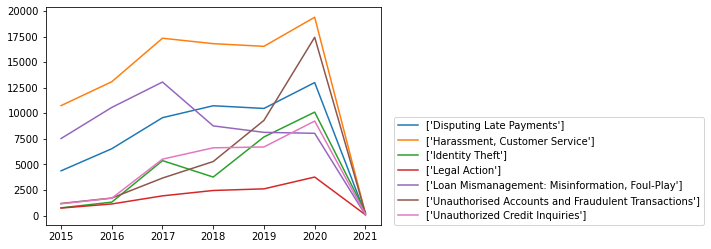

In [22]:
for x in range(7, 14): 
  plt.plot(df_topic[df_topic['Topic_Num'] == x]['Topic'].groupby(df_topic['year']).agg('count'), label = df_topic[df_topic['Topic_Num'] == x]['Topic'].unique())
  plt.legend(loc=(1.04,0))

In [23]:
#Summary Stats of Topic Weight

print("Max: {}".format(df_topic['max_prob'].max()))
print("Min: {}".format(df_topic['max_prob'].min()))
print("Average: {}".format(df_topic['max_prob'].mean()))
print("Median: {}".format(df_topic['max_prob'].median()))
print("Most frequent value: {}".format(df_topic['max_prob'].round(3).value_counts().idxmax()))

Max: 0.9890187974092459
Min: 0.106486737078184
Average: 0.3727571911911815
Median: 0.34917446135701097
Most frequent value: 0.303


Text(0.5, 0.98, 'Scatterplot of Topic Weights, Split by Topic; All Weights.')

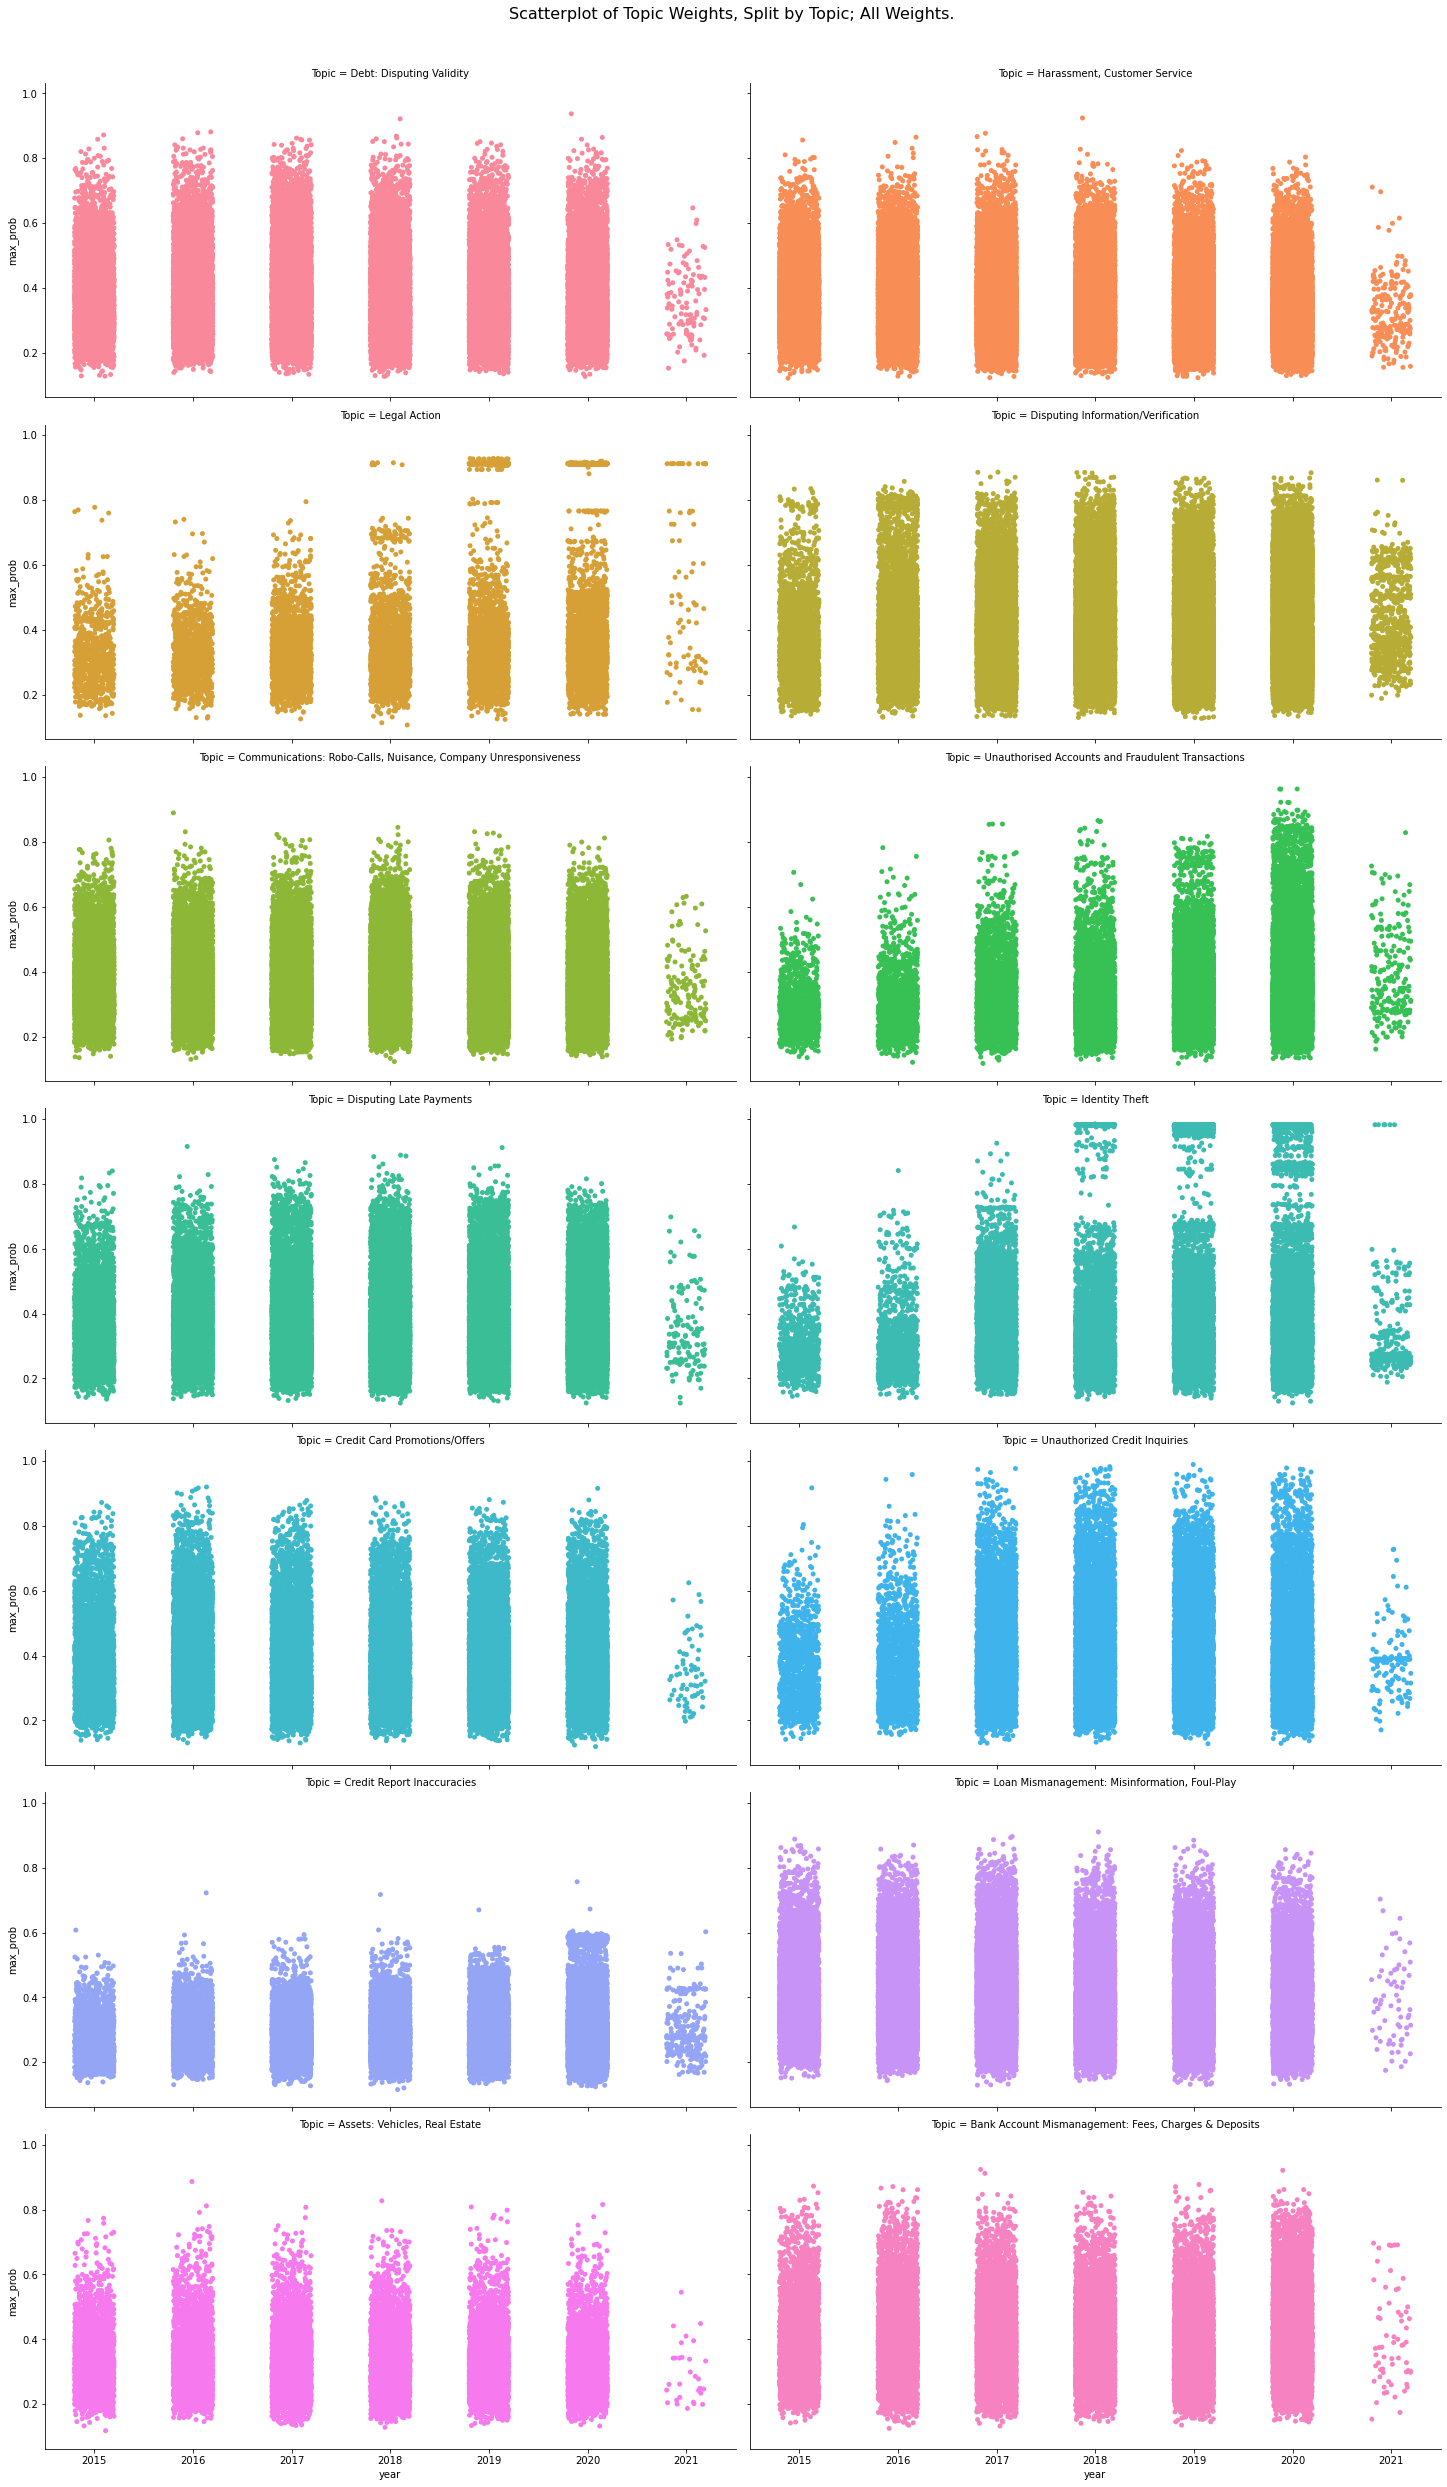

In [24]:
p = sns.catplot(x="year", y='max_prob', hue="Topic", col = "Topic", col_wrap = 2,
                   kind='strip', aspect=2, jitter=0.2, data=df_topic)
p.fig.subplots_adjust(top=0.95)
p.fig.suptitle("Scatterplot of Topic Weights, Split by Topic; All Weights.", fontsize=16)

Resources referenced for this segment: 
- https://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/#topic=16&lambda=0.06&term= (Four Part Series, with four different approaches)

### Smoothing or regression analysis

Rolling Means of the Topic Weights across Months, for one topic, per year

In [25]:
def create_plotpoint(df, y_value, hue=None, col=None, wrap=None, size=6, aspect=2, title=""):
    p = sns.factorplot(x="month", y=y_value, kind='point', 
                        hue=hue, 
                       col=col, col_wrap=wrap, 
                       size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p

In [26]:
t4 = df_topic.query(f'Topic_Num == 4 & year == 2015')

t4

,Topic,max_prob,date_rec,year,month,Topic_Num
13809,Credit Report Inaccuracies,0.251934,2015-12-25,2015,12,4
16610,Credit Report Inaccuracies,0.213557,2015-11-10,2015,11,4
170890,Credit Report Inaccuracies,0.218618,2015-08-18,2015,8,4
238617,Credit Report Inaccuracies,0.226428,2015-06-18,2015,6,4
256977,Credit Report Inaccuracies,0.172529,2015-06-18,2015,6,4
...,...,...,...,...,...,...
603509,Credit Report Inaccuracies,0.292530,2015-11-01,2015,11,4
604123,Credit Report Inaccuracies,0.174212,2015-06-24,2015,6,4
604220,Credit Report Inaccuracies,0.236206,2015-07-01,2015,7,4
604421,Credit Report Inaccuracies,0.302331,2015-07-21,2015,7,4


In [27]:
t4grouped = t4.groupby('month')['max_prob'].mean()

t4grouped

month
3     0.279604
4     0.276427
5     0.269438
6     0.273258
7     0.270827
8     0.277219
9     0.268674
10    0.274483
11    0.279457
12    0.279827
Name: max_prob, dtype: float64

In [28]:
t4rolling = t4grouped.rolling(2).mean().reset_index()
t4rolling.columns = ['month', 'rolling_mean']

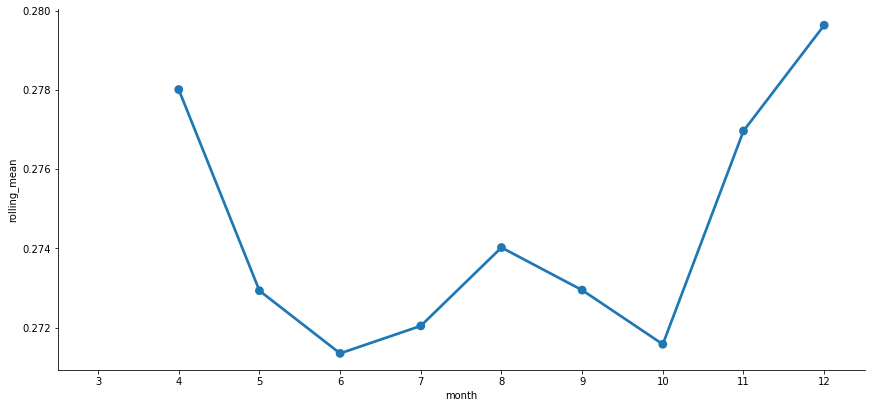

In [29]:
create_plotpoint(t4rolling, 'rolling_mean')

In [30]:
def rolling_mean_topic_weight(Topic_Num, year): 
    
    def create_plotpoint(df, y_value, hue=None, col=None, wrap=None, size=6, aspect=2, title=""):
        p = sns.factorplot(x="month", y=y_value, kind='point', 
                        hue=hue, 
                       col=col, col_wrap=wrap, 
                       size=size, aspect=aspect, data=df)
        p.fig.subplots_adjust(top=0.9)
        p.fig.suptitle(title, fontsize=16)
        return p

    t = df_topic.query(f'Topic_Num == {Topic_Num} & year == {year}')
    tgrouped = t.groupby('month')['max_prob'].mean()
    t_rolling = tgrouped.rolling(2).mean().reset_index()
    t_rolling.columns = ['month', 'rolling_mean']
    create_plotpoint(t_rolling, 'rolling_mean')

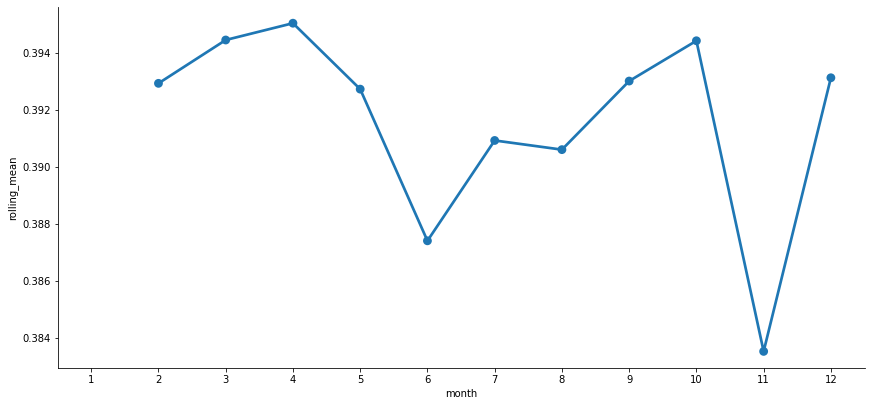

In [31]:
rolling_mean_topic_weight(1, 2019) #example

### Average Topic Weight Per Year

In [32]:
total_docs = df_topic.year.value_counts()

In [33]:
total_docs = pd.DataFrame(total_docs).reset_index()
total_docs.columns = ['year', 'total_docs']
total_docs

,year,total_docs
0,2020,164002
1,2019,124764
2,2018,118475
3,2017,115167
4,2016,77819
5,2015,54748
6,2021,2688


Data is definitely more skewed recent years, sans 2021.

In [34]:
df_avg = df_topic.groupby(['year', 'Topic']).agg({'max_prob': 'sum'}).reset_index()
df_avg.head()

#summing max_probs for topic, per year

,year,Topic,max_prob
0,2015,"Assets: Vehicles, Real Estate",886.827743
1,2015,"Bank Account Mismanagement: Fees, Charges & De...",1389.303709
2,2015,"Communications: Robo-Calls, Nuisance, Company ...",2605.791542
3,2015,Credit Card Promotions/Offers,1421.968606
4,2015,Credit Report Inaccuracies,647.502866


In [35]:
df_avg = df_avg.merge(total_docs, on="year", how="left")
print(df_avg.head())
print(df_avg.tail())
df_avg.shape

   year  ... total_docs
0  2015  ...      54748
1  2015  ...      54748
2  2015  ...      54748
3  2015  ...      54748
4  2015  ...      54748

[5 rows x 4 columns]
    year  ... total_docs
93  2021  ...       2688
94  2021  ...       2688
95  2021  ...       2688
96  2021  ...       2688
97  2021  ...       2688

[5 rows x 4 columns]


(98, 4)

In [36]:
df_avg['average_weight'] = df_avg['max_prob'] / df_avg['total_docs'] #total_documents within the year

In [37]:
df_avg.drop('max_prob', axis = 1, inplace = True)
df_avg

,year,Topic,total_docs,average_weight
0,2015,"Assets: Vehicles, Real Estate",54748,0.016198
1,2015,"Bank Account Mismanagement: Fees, Charges & De...",54748,0.025376
2,2015,"Communications: Robo-Calls, Nuisance, Company ...",54748,0.047596
3,2015,Credit Card Promotions/Offers,54748,0.025973
4,2015,Credit Report Inaccuracies,54748,0.011827
...,...,...,...,...
93,2021,Identity Theft,2688,0.039091
94,2021,Legal Action,2688,0.015996
95,2021,"Loan Mismanagement: Misinformation, Foul-Play",2688,0.009658
96,2021,Unauthorised Accounts and Fraudulent Transactions,2688,0.031703


In [38]:
def create_bar(df, y_value, hue=None, col=None, wrap=None, size=5, aspect=1.5, title=""):
    p = sns.factorplot(x="year", y=y_value, kind='bar', hue=hue, 
                       col=col, col_wrap=wrap, size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p

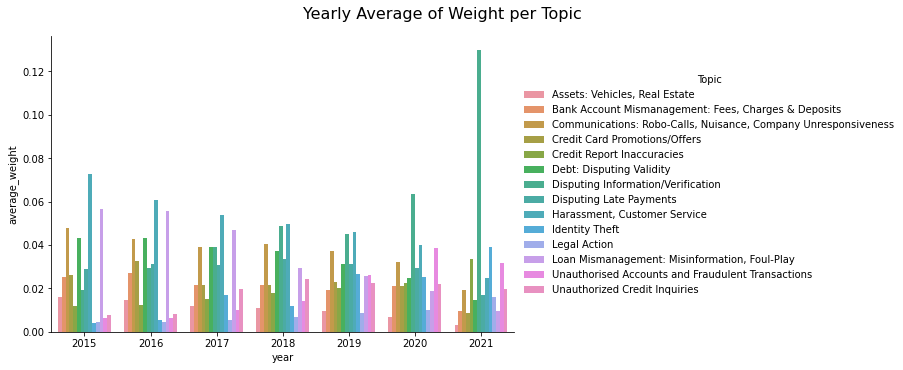

In [39]:
create_bar(df_avg, 'average_weight', hue="Topic",
          title="Yearly Average of Weight per Topic")

In [40]:
def create_pointplot(df, y_value, hue=None, col=None, wrap=None, size=5, aspect=1.5, title=""):
    p = sns.factorplot(x="year", y=y_value, kind='point', hue=hue, 
                       col=col, col_wrap=wrap, size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p

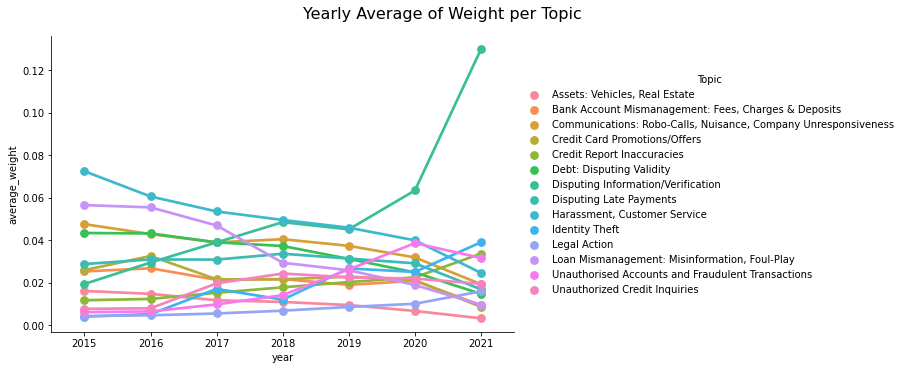

In [41]:
create_pointplot(df_avg, 'average_weight', hue="Topic",
                title="Yearly Average of Weight per Topic")